In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
class ModulationClassifier(torch.nn.Module):
    def __init__(self, num_classes=11):
        super(ModulationClassifier, self).__init__()
        
        # Treating input as 2x128 image with 1 channel (depth 1)
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1,3), padding=(0,2)), torch.nn.BatchNorm2d(256))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2,3), padding=(0,2)), torch.nn.BatchNorm2d(80))
        #self.fc1   = torch.nn.Linear(in_features=10560, out_features=256)
        #self.fc2   = torch.nn.Linear(in_features=256, out_features=num_classes)
        self.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=10560, out_features=256),
                                              torch.nn.ReLU(True),
                                             torch.nn.Linear(in_features=256, out_features=11))

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y2 = F.relu(self.conv2(y1))
        y3 = torch.flatten(y2, 1)
        y4 = self.classifier(y3)
        return y4

In [3]:
fname = 'RML2016.10a_dict.pkl'
f = open(fname,'rb')
input_data_dict = pickle.load(f, encoding='latin1')

"""
Data size is 1000*2*128
Consider it as 1000 images of size 1*2*128. Where 1 is the color channel.
We need the data in this format:

image - mod - snr
image - mod - snr
image - mod - snr

Create 3 arrays:
image, mod, snr
"""

input_data_dict_keys = sorted(input_data_dict.keys())

modulation_types    = [input_data_dict_keys[i*20][0] for i in range(0,11)]
snr_types           = [input_data_dict_keys[i][1] for i in range(0,20)]

print(modulation_types)
print(snr_types)


image = []
modulation = []
snr = []

print(np.shape(image), np.shape(modulation), np.shape(snr))

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[10:]:
        #print(m,str(s))
        image.extend(input_data_dict[(m,s)])
        modulation.extend([m_cnt for _ in range(0,1000)])
        snr.extend([s for _ in range(0,1000)])
        
#print(np.shape(image), np.shape(modulation), np.shape(snr))
image = np.array(image)
modulation = np.array(modulation)
snr = np.array(snr)

"""
image = np.zeros((220000,2,128), dtype='float32')
modulation = np.zeros((220000), dtype='int32')
snr = np.zeros((220000), dtype='int32')
cnt = 0

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types:
        print(cnt, m_cnt,s)
        #print(input_data_dict[(m,s)].shape)
        image[cnt:cnt+1000,:,:] = np.array(input_data_dict[(m,s)])
        modulation[cnt:cnt+1000] = np.array([m_cnt for _ in range(0,1000)])
        snr[cnt:cnt+1000] = np.array([s for _ in range(0,1000)])
        #print(image[cnt:cnt+1000,:,:], modulation[cnt:cnt+1000], snr[cnt:cnt+1000])
        cnt += 1000
"""

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
(0,) (0,) (0,)


"\nimage = np.zeros((220000,2,128), dtype='float32')\nmodulation = np.zeros((220000), dtype='int32')\nsnr = np.zeros((220000), dtype='int32')\ncnt = 0\n\nfor m_cnt,m in enumerate(modulation_types,0):\n    for s in snr_types:\n        print(cnt, m_cnt,s)\n        #print(input_data_dict[(m,s)].shape)\n        image[cnt:cnt+1000,:,:] = np.array(input_data_dict[(m,s)])\n        modulation[cnt:cnt+1000] = np.array([m_cnt for _ in range(0,1000)])\n        snr[cnt:cnt+1000] = np.array([s for _ in range(0,1000)])\n        #print(image[cnt:cnt+1000,:,:], modulation[cnt:cnt+1000], snr[cnt:cnt+1000])\n        cnt += 1000\n"

### Add negative SNR type data.

In [4]:
image1 = []
modulation1 = []
snr1 = []

print(np.shape(image), np.shape(modulation), np.shape(snr))

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[:10]:
        #print(m,str(s))
        image1.extend(input_data_dict[(m,s)])
        modulation1.extend([m_cnt for _ in range(0,1000)])
        snr1.extend([s for _ in range(0,1000)])
        
#print(np.shape(image), np.shape(modulation), np.shape(snr))
image1 = np.array(image1)
modulation1 = np.array(modulation1)
snr1 = np.array(snr1)


(110000, 2, 128) (110000,) (110000,)


In [4]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, X,Y,Z, transform=None):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        rX, rY, rZ = torch.unsqueeze(torch.from_numpy(self.X[idx]),dim=0).float(), torch.tensor(self.Y[idx]), torch.tensor(self.Z[idx])
        if(self.transform):
            rX, rY, rZ = self.transform(self.X[idx]),torch.tensor(self.Y[idx]),torch.tensor(self.Z[idx])
            
        return rX, rY, rZ

In [6]:
#dataset = [image, modulation, snr]
transformed_dataset = myDataset(image, modulation, snr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
#rX, rY, rZ = torch.unsqueeze(torch.from_numpy(image[0]),dim=0).float(), torch.tensor(modulation[0]), torch.tensor(snr[0])
#print(type(rY))
transformed_dataset2 = myDataset(image1, modulation1, snr1,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))

dataset_len = len(image)
l = list(range(0, dataset_len))
np.random.shuffle(l)
split = 0.5
train_indices, test_indices = l[:int(split*dataset_len)],l[int(split*dataset_len):]

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)

# train_sampler=torch.utils.data.SequentialSampler(train_indices)
# test_sampler=torch.utils.data.SequentialSampler(test_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
testloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
testloader2 = torch.utils.data.DataLoader(transformed_dataset2, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [7]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

cuda:0
ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 256, 2, 3])

In [9]:
num_epochs = 100
epoch_loss_array = np.zeros(num_epochs)

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        #x_mean = torch.mean(x, 1, keepdims=True)
        #print(x.size(), y.size(), z.size(), x_mean.size())
        #x = x - x_mean
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        #print(torch.argmax(y_pred, 1).size())
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
        #print( y, torch.argmax(y_pred,1))
        #break
        
    print(running_loss/len(trainloader))

print('Finished Training')

0.8112779238889384
0.5048488896946575
0.4445687431235646
0.39716524918412055
0.373049094233402
0.3410013764403587
0.30595230162143705
0.28070604104635327
0.2584812211089356
0.2301949530146843
0.20797962376544643
0.1862474104866039
0.16476252461935198
0.15026853127881537
0.1371432600672855
0.12440655713164529
0.11337660551937513
0.10481442762322205
0.09568323979890624
0.08852812072565389
0.08504276727001335
0.08154836076116839
0.08059946495259918
0.07965323317709357
0.07809596571118332
0.07890419444545757
0.0813767320887987
0.08188883928192216
0.07455072303324245
0.07446715266898621
0.070875500601738
0.06943702712481799
0.06917436970181243
0.06672620515144148
0.06675414936833604
0.0657540614435146
0.06531778218354596
0.06546319530800332
0.06383538608287656
0.06333799651975548
0.062443177687913874
0.06326699684005838
0.0623754377281943
0.0608642595105393
0.05971358559679153
0.057609103316831035
0.05749940107208352
0.0572495705513067
0.057438565444114596
0.05712867930618137
0.055006472792

In [10]:
PATH = './temp_model_1.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

for i,data in enumerate(testloader2):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 36.846061 %


In [11]:
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, values[0]/values[1]))

SNR -20 Accuracy 0.091091
SNR -18 Accuracy 0.091273
SNR -16 Accuracy 0.090818
SNR -14 Accuracy 0.091364
SNR -12 Accuracy 0.092364
SNR -10 Accuracy 0.094545
SNR -8 Accuracy 0.105727
SNR -6 Accuracy 0.147818
SNR -4 Accuracy 0.239818
SNR -2 Accuracy 0.501909
SNR 0 Accuracy 0.721704
SNR 2 Accuracy 0.780959
SNR 4 Accuracy 0.792556
SNR 6 Accuracy 0.802469
SNR 8 Accuracy 0.806615
SNR 10 Accuracy 0.811562
SNR 12 Accuracy 0.819533
SNR 14 Accuracy 0.805682
SNR 16 Accuracy 0.809837
SNR 18 Accuracy 0.808909


### Re-train data with -SNR values to see accuracy.  
Only for 50 epochs because it is taking too long and also because I ran it for 100 epochs and it crashed the kernel. 
Also the loss seemed to converge so I think 50 is okay.

In [8]:
image = []
modulation = []
snr = []


for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types:
        #print(m,str(s))
        image.extend(input_data_dict[(m,s)])
        modulation.extend([m_cnt for _ in range(0,1000)])
        snr.extend([s for _ in range(0,1000)])
        
image = np.array(image)
modulation = np.array(modulation)
snr = np.array(snr)

In [9]:
#dataset = [image, modulation, snr]
transformed_dataset = myDataset(image, modulation, snr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
#rX, rY, rZ = torch.unsqueeze(torch.from_numpy(image[0]),dim=0).float(), torch.tensor(modulation[0]), torch.tensor(snr[0])
#print(type(rY))

dataset_len = len(image)
l = list(range(0, dataset_len))
np.random.shuffle(l)
split = 0.75
train_indices, test_indices = l[:int(split*dataset_len)],l[int(split*dataset_len):]

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
testloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)


In [10]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

cuda:0
ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 256, 2, 3])

In [13]:
num_epochs = 50
epoch_loss_array = np.zeros(num_epochs)

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        #x_mean = torch.mean(x, 1, keepdims=True)
        #print(x.size(), y.size(), z.size(), x_mean.size())
        #x = x - x_mean
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        #print(torch.argmax(y_pred, 1).size())
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
        #print( y, torch.argmax(y_pred,1))
        #break
        
    print(running_loss/len(trainloader))

print('Finished Training')

1.1534653807333273
1.1108761246352232
1.0486861754757488
0.9816833774248759
0.8983660638794418
0.7996799930121548
0.6895921946727028
0.5682824958433477
0.45163143693014635
0.34802322284888854
0.25600399027845655
0.21272994066740192
0.1542755943022726
0.1229332166009171
0.10040969415748305
0.08198989807635315
0.09131508919504262
0.11216388211636118
0.109900020086026
0.08718934008606183
0.03792133937741435
0.035993806691479314
0.034323670258817746
0.035837647760676786
0.03369242050215718
0.03304080106606779
0.03238219274857709
0.033089952196839245
0.032620657186291015
0.07077711184704026
0.04435664832938549
0.036097655777436816
0.05442213343037653
0.06511778993488744
0.039111996147521706
0.03281014509094778
0.03075558760658253
0.02985337482000044
0.029203764326119607
0.029196680845447288
0.028644101102222767
Finished Training


In [14]:
PATH = './temp_model_2.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader):
    #print(i)
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

# for i,data in enumerate(testloader2):
#     x,y,z = data
#     x,y,z = x.to(device), y.to(device), z.to(device)

#     y_pred = model1.forward(x)
#     correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
#     snr_value = z.item()

#     snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
#     snr_accuracy[str(int(snr_value))][1] += 1
    
#     total += 1 #Increase by batch size

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 49.214545 %


In [15]:
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, values[0]/values[1]))

SNR -20 Accuracy 0.099211
SNR -18 Accuracy 0.093333
SNR -16 Accuracy 0.098722
SNR -14 Accuracy 0.110259
SNR -12 Accuracy 0.137463
SNR -10 Accuracy 0.198134
SNR -8 Accuracy 0.265328
SNR -6 Accuracy 0.348733
SNR -4 Accuracy 0.476824
SNR -2 Accuracy 0.581071
SNR 0 Accuracy 0.667037
SNR 2 Accuracy 0.688477
SNR 4 Accuracy 0.748724
SNR 6 Accuracy 0.744385
SNR 8 Accuracy 0.761368
SNR 10 Accuracy 0.766753
SNR 12 Accuracy 0.763316
SNR 14 Accuracy 0.755922
SNR 16 Accuracy 0.762380
SNR 18 Accuracy 0.764727


### Above we have discussed that having -SNR values in our model will hinder our accuracy and we have shown that that is true.


### Now, lets try to setup a validation set and do some hyperparameter tuning.

https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5


In [84]:
image = []
modulation = []
snr = []

print(np.shape(image), np.shape(modulation), np.shape(snr))

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[10:]:
        #print(m,str(s))
        image.extend(input_data_dict[(m,s)])
        modulation.extend([m_cnt for _ in range(0,1000)])
        snr.extend([s for _ in range(0,1000)])
        
#print(np.shape(image), np.shape(modulation), np.shape(snr))
image = np.array(image)
modulation = np.array(modulation)
snr = np.array(snr)

(0,) (0,) (0,)


In [85]:
transformed_dataset = myDataset(image, modulation, snr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
#transformed_dataset2 = myDataset(image1, modulation1, snr1,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))

dataset_len = len(image)
l = list(range(0, dataset_len))
np.random.shuffle(l)
#train_split = 0.7
#val_split = 0.05
#test_split = 0.25

split = 0.7

#train_indices, test_indices, val_indices = l[:int(train_split*dataset_len)], l[int(test_split*dataset_len):], l[int(val_split*dataset_len):]
train_indices, test_indices = l[:int(split*dataset_len)], l[int(split*dataset_len):]

valsplit = 0.5 ##meaning, 70% of +SNR data used for training, 15% goes to validation 15% goes to testing
test_indices, val_indices = test_indices[:int(valsplit*len(test_indices))], test_indices[int(valsplit*len(test_indices)):]

print(len(train_indices), len(test_indices),len(val_indices))

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)
val_sampler=torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
testloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
#testloader2 = torch.utils.data.DataLoader(transformed_dataset2, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

valloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128, shuffle=False, num_workers=2, sampler=val_sampler, pin_memory=True)


print("Size of trainLoader: ", len(trainloader))
print("Size of testLoader: ", len(testloader))
print("Size of ValLoader: ", len(valloader))

77000 16500 16500
Size of trainLoader:  602
Size of testLoader:  16500
Size of ValLoader:  129


In [86]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

cuda:0
ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 256, 2, 3])

In [87]:
def validation_function(net, criterion):
    PATH = './temp_model_val.pth'
    torch.save(net.state_dict(), PATH) 

    model1 = ModulationClassifier()
    model1.to(device)
    model1.load_state_dict(torch.load(PATH))
    
    val_loss = 0
    total = 0
    model1.eval()
    for i, data in enumerate(valloader):
        xv, yv, zv = data
        xv, yv, zv = xv.to(device), yv.to(device), zv.to(device)

        yv_pred = model1.forward(xv)
        batchv_loss = criterion(yv_pred, yv.long())
        val_loss += batchv_loss.item()

        total += 128
        
    #print(val_loss)
        
    return val_loss

In [88]:
num_epochs = 25
epoch_loss_array = np.zeros(num_epochs)

historyEpoch = []
historyLoss = []
historyValLoss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    correct_test = 0
    historyEpoch.append(epoch)
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        correct_test += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        #print(y_pred)
        #print(loss.item())
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    valloss = validation_function(net, criterion)
    #correct, total, snr_accuracy = testing_function(net, criterion)
    #plt.figure(figsize=(15,7))
    #plt.plot(list(range(0,20,2)),[values[0]/values[1] for key,values in snr_accuracy.items()])
    
    
#     total = 0
#     val_loss = 0
    
#     with torch.no_grad():
#         for j, dataval in enumerate(valloader):
#             xv, yv, zv = dataval
#             xv, yv, zv = xv.to(device), yv.to(device), zv.to(device)
            
#             yv_pred = net.forward(xv)
#             batchv_loss = criterion(yv_pred, yv)
#             val_loss += batchv_loss.item()
            
#             total += 128
            
    print("Epoch #", epoch, 'Correct:', correct_test,"Loss: ", running_loss/len(trainloader), 'Val Loss', valloss/len(valloader))
    historyLoss.append(running_loss/len(trainloader))
    historyValLoss.append(valloss/len(valloader))

print('Finished Training')
plt.show()

Epoch # 0 Correct: 52237 Loss:  0.7209601718127926 Val Loss 0.5248683778814567
Epoch # 1 Correct: 58922 Loss:  0.47437593306219855 Val Loss 0.4251047934210578
Epoch # 2 Correct: 60554 Loss:  0.4210029142936599 Val Loss 0.4088867373706758
Epoch # 3 Correct: 62089 Loss:  0.38223698195626965 Val Loss 0.39935529486153476
Epoch # 4 Correct: 63176 Loss:  0.3537909023686501 Val Loss 0.4109544585379519
Epoch # 5 Correct: 64088 Loss:  0.32829212295850646 Val Loss 0.39014030311458797
Epoch # 6 Correct: 65333 Loss:  0.29996658710645285 Val Loss 0.3968972099381824
Epoch # 7 Correct: 66511 Loss:  0.27216769767263005 Val Loss 0.412706860969233
Epoch # 8 Correct: 67564 Loss:  0.24631090308740686 Val Loss 0.43173877998839977
Epoch # 9 Correct: 68460 Loss:  0.2255395496158901 Val Loss 0.4560415223818417
Epoch # 10 Correct: 69515 Loss:  0.20061323952635263 Val Loss 0.45992083651150845
Epoch # 11 Correct: 70200 Loss:  0.18056590992499427 Val Loss 0.47970535496408623
Epoch # 12 Correct: 70668 Loss:  0.169

In [93]:
PATH = './temp_model_xyz.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

# for i,data in enumerate(testloader2):
#     x,y,z = data
#     x,y,z = x.to(device), y.to(device), z.to(device)

#     y_pred = model1.forward(x)
#     correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
#     snr_value = z.item()

#     snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
#     snr_accuracy[str(int(snr_value))][1] += 1
    
#     total += 1 #Increase by batch size

print('%d %d Accuracy of the network on the test images: %f %%' % (correct, total,
    100 * correct / total))

KeyboardInterrupt: 

In [90]:
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, values[0]/values[1]))

SNR 0 Accuracy 0.743125
SNR 2 Accuracy 0.796493
SNR 4 Accuracy 0.808184
SNR 6 Accuracy 0.825416
SNR 8 Accuracy 0.824169
SNR 10 Accuracy 0.821322
SNR 12 Accuracy 0.828877
SNR 14 Accuracy 0.832139
SNR 16 Accuracy 0.823091
SNR 18 Accuracy 0.817518


In [91]:
## i forgot to divide historyValLoss by total (which was 129)
#tempList = np.divide(historyValLoss, 129)

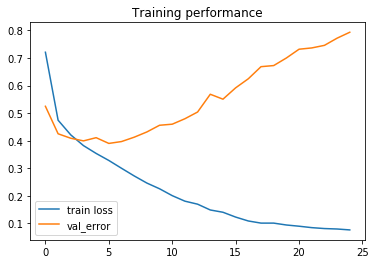

In [94]:
plt.figure()
plt.title('Training performance')
plt.plot(historyEpoch, historyLoss, label='train loss')
plt.plot(historyEpoch, historyValLoss, label='val_error')
plt.legend()